## In this notebook

- Create xG model.

In [1]:
from enum import Enum
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# plots
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
DATA_FOLDER_PATH = Path("/usr/src/app/data/shots/")
DATA_FILE_NAME = "20240616_base_shots.parquet"

## Read data

In [3]:
cols_to_keep = [
    "game_id",
    "away_team_id",
    "home_team_id",
    "period",
    "period_type",
    "time_in_period",
    "situation_code",
    "home_team_defending_side",
    "event_type",
    "sort_order",
    "x_coord",
    "y_coord",
    "zone_code",
    "event_owner_team_id",
    "shot_type",
    # "shooting_player_id",
    # "goalie_in_net_id",
]

df = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME).loc[:, cols_to_keep]

# filter out blocked shots
df = df.loc[df.event_type != "blocked-shot"].reset_index(drop=True)

df.tail()

,game_id,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type
447085,2022020792,4,52,3,REG,16:36,1551,right,missed-shot,773,-34,23,O,52.0,snap
447086,2022020792,4,52,3,REG,17:40,1551,right,shot-on-goal,782,-3,36,N,52.0,wrist
447087,2022020792,4,52,3,REG,19:06,1551,right,shot-on-goal,800,-47,11,O,52.0,snap
447088,2022020792,4,52,3,REG,19:13,1551,right,shot-on-goal,805,-53,-25,O,52.0,wrist
447089,2022020792,4,52,3,REG,19:54,1551,right,shot-on-goal,809,-10,30,N,52.0,wrist


## Create features

In [4]:
# normalize coordinates

def norm_coord(row: dict, coord_type: str) -> int:
    home_team_defending_side = row["home_team_defending_side"]
    home_team_id = row["home_team_id"]
    event_owner_team_id = row["event_owner_team_id"]
    coord = row[f"{coord_type}_coord"]
    
    
    if (
        (home_team_defending_side == "left" and home_team_id != event_owner_team_id) or 
        (home_team_defending_side == "right" and home_team_id == event_owner_team_id)
    ):
        return coord * (-1)
    
    return coord

df["x_coord_norm"] = df.apply(lambda row: norm_coord(row=row, coord_type="x"), axis=1)
df["y_coord_norm"] = df.apply(lambda row: norm_coord(row=row, coord_type="y"), axis=1)

In [5]:
# compute distance from goal, and shot angle

class GoalCoord(Enum):
    X = 89
    Y = 0

df["distance_from_goal"] = np.sqrt(
    (df["x_coord_norm"] - GoalCoord.X.value) ** 2 
    + (df["y_coord_norm"] - GoalCoord.Y.value) ** 2
)
df["angle"] = np.degrees(
    np.arctan2(df["y_coord_norm"].abs(), GoalCoord.X.value - df["x_coord_norm"].abs())
)

In [57]:
# compute time between the previous and current shot

df["time_in_period_seconds"] = (
    df.time_in_period.str.split(":").str[0].astype(int).mul(60)
    + df.time_in_period.str.split(":").str[1].astype(int)
)

df["time_between_shots"] = (
    df
    .groupby(by=["game_id", "period", "period_type", "event_owner_team_id"])
    .time_in_period_seconds
    .transform(lambda x: x - x.shift())
)

In [58]:
df.head()

,game_id,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type,x_coord_norm,y_coord_norm,distance_from_goal,angle,time_in_period_seconds,time_between_shots
0,2023020255,54,4,1,REG,01:56,1551,right,shot-on-goal,30,61,10,O,54.0,wrist,61,10,29.732137,19.653824,116,NaN
1,2023020255,54,4,1,REG,02:12,1551,right,missed-shot,36,37,0,O,54.0,wrist,37,0,52.000000,0.000000,132,16.0
2,2023020255,54,4,1,REG,02:33,1551,right,missed-shot,38,81,-6,O,54.0,wrist,81,-6,10.000000,36.869898,153,21.0
3,2023020255,54,4,1,REG,04:40,1551,right,shot-on-goal,67,-58,-32,O,4.0,wrist,58,32,44.553339,45.909380,280,NaN
4,2023020255,54,4,1,REG,04:53,1551,right,shot-on-goal,70,-39,-28,O,4.0,wrist,39,28,57.306195,29.248826,293,13.0


## Plot data

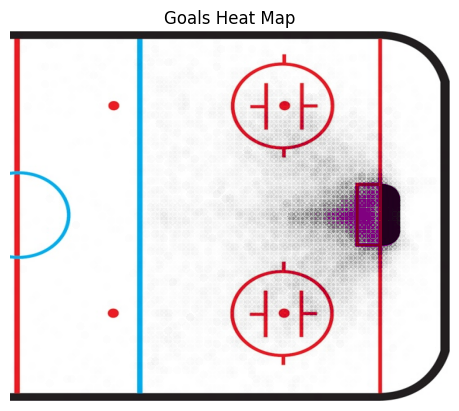

In [66]:
# plot goals heat map

df_goals = df.loc[(df.event_type == "goal") & (df.x_coord_norm >= 0)]

img = plt.imread("/usr/src/app/playground/images/half_rink_diagram.jpg")
plt.imshow(
    img, 
    zorder=0, 
    extent=[
        df_goals.x_coord_norm.min(),
        df_goals.x_coord_norm.max(),
        df_goals.y_coord_norm.min(),
        df_goals.y_coord_norm.max(),
    ],
)

ax = sns.scatterplot(
    data=df_goals,
    x="x_coord_norm", 
    y="y_coord_norm", 
    hue="event_type",
    alpha=0.005,
    zorder=1,
    # palette=["orange"],
    # palette=["y"],
    palette=["purple"],
)

# hide axis
ax.axis("off")

# hide legend
ax.get_legend().set_visible(False)

# add title
ax.set_title("Goals Heat Map")

plt.show()